# Analysis: Does Deliberation Improve LLM Forecasting?

We test whether structured deliberation improves forecasting accuracy across four real-world scenarios.

## A. Setup

In [214]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

DATA_DIR = "../data/analysis"

In [215]:
# Load data
condition_pairs = pd.read_csv(f"{DATA_DIR}/condition_pairs.csv")
questions = pd.read_csv(f"{DATA_DIR}/questions.csv")

print(f"Agent-level observations: {len(condition_pairs)}")
print(f"Questions: {len(questions)}")
print(f"Conditions: {condition_pairs['condition'].nunique()}")

Agent-level observations: 3636
Questions: 202
Conditions: 6


### Overview

**Research Question:** Does deliberation improve LLM forecasting accuracy?

**Method:** We test deliberation in four scenarios representing realistic deployment configurations.

| Scenario | Models | Information | Real-world analog |
|----------|--------|-------------|-------------------|
| `diverse_info` | GPT-5, Sonnet, Pro | Each has 1/3 | Specialist team |
| `diverse_full` | GPT-5, Sonnet, Pro | All have full | Generalist team |
| `homo_info` | 3× same model | Each has 1/3 | Single model + distributed RAG |
| `homo_full` | 3× same model | All have full | Single model ensemble |

**Unit of analysis:** Groups of 3 agents. Forecasts aggregated using the median.

**Metric:** Log Loss (cross-entropy). Lower is better.

**Test:** Paired t-test comparing independent vs deliberative forecasts (n = 202 questions per scenario).

In [216]:
def log_loss(prob, outcome, eps=1e-3):
    """Cross-entropy loss. Lower is better."""
    p = np.clip(prob / 100, eps, 1 - eps)
    return -(outcome * np.log(p) + (1 - outcome) * np.log(1 - p))

In [217]:
# Aggregate to group medians
PRIMARY_CONDITIONS = ['diverse_info', 'diverse_full', 'homo_info', 'homo_full']

factorial_pairs = condition_pairs[condition_pairs['condition'].isin(PRIMARY_CONDITIONS)].copy()

medians = factorial_pairs.groupby(['question_id', 'condition', 'resolution']).agg(
    n_agents=('model', 'count'),
    independent_median=('independent_prob', 'median'),
    deliberative_median=('deliberative_prob', 'median')
).reset_index()

# Compute log loss scores
medians['logloss_ind'] = log_loss(medians['independent_median'], medians['resolution'])
medians['logloss_del'] = log_loss(medians['deliberative_median'], medians['resolution'])
medians['logloss_change'] = medians['logloss_del'] - medians['logloss_ind']

print(f"Group-level observations: {len(medians)} ({len(medians)//4} questions × 4 scenarios)")

Group-level observations: 808 (202 questions × 4 scenarios)


## B. Primary Analysis: Does Deliberation Help?

In [218]:
# Descriptive statistics by scenario
def summarize_scenario(df, condition):
    subset = df[df['condition'] == condition]
    return {
        'Scenario': condition,
        'n': len(subset),
        'Independent (mean)': subset['logloss_ind'].mean(),
        'Independent (sd)': subset['logloss_ind'].std(),
        'Deliberative (mean)': subset['logloss_del'].mean(),
        'Deliberative (sd)': subset['logloss_del'].std(),
        'Change (mean)': subset['logloss_change'].mean(),
        'Change (sd)': subset['logloss_change'].std(),
    }

descriptives = pd.DataFrame([summarize_scenario(medians, c) for c in PRIMARY_CONDITIONS])
descriptives = descriptives.round(4)
descriptives

,Scenario,n,Independent (mean),Independent (sd),Deliberative (mean),Deliberative (sd),Change (mean),Change (sd)
0,diverse_info,202,0.4750,0.4938,0.4527,0.5365,-0.0224,0.2372
1,diverse_full,202,0.5011,0.6082,0.4813,0.6176,-0.0199,0.1169
2,homo_info,202,0.5170,0.6115,0.5249,0.6768,0.0079,0.3076
3,homo_full,202,0.5245,0.6527,0.5445,0.6960,0.0200,0.1936


In [219]:
# Paired t-tests: Does deliberation improve accuracy in each scenario?
def test_deliberation(df, condition):
    subset = df[df['condition'] == condition]
    t, p = stats.ttest_rel(subset['logloss_ind'], subset['logloss_del'])
    change = subset['logloss_change'].mean()
    direction = "improves" if change < 0 else "worsens"
    return {
        'Scenario': condition,
        'Mean Change': change,
        'Direction': direction,
        't': t,
        'p': p,
    }

primary_results = pd.DataFrame([test_deliberation(medians, c) for c in PRIMARY_CONDITIONS])
primary_results = primary_results.round(4)
primary_results

,Scenario,Mean Change,Direction,t,p
0,diverse_info,-0.0224,improves,1.3402,0.1817
1,diverse_full,-0.0199,improves,2.4137,0.0167
2,homo_info,0.0079,worsens,-0.3633,0.7168
3,homo_full,0.0200,worsens,-1.4682,0.1436


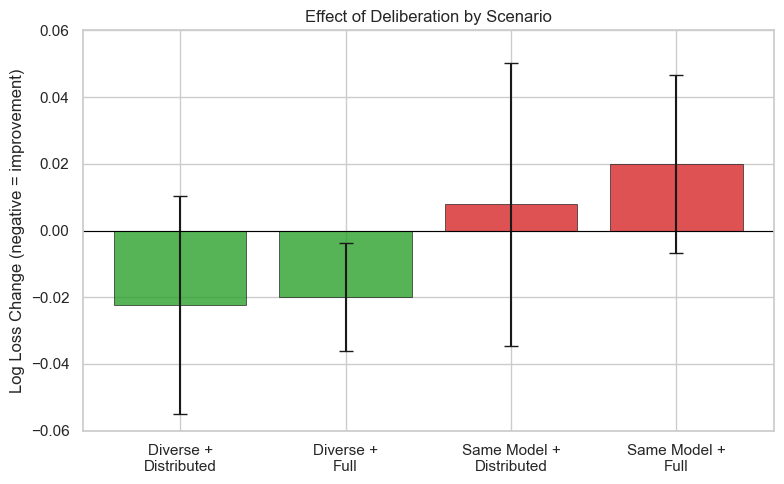

In [220]:
# Visualization
fig, ax = plt.subplots(figsize=(8, 5))

means = medians.groupby('condition')['logloss_change'].agg(['mean', 'sem']).reindex(PRIMARY_CONDITIONS)
colors = ['#2ca02c' if m < 0 else '#d62728' for m in means['mean']]

bars = ax.bar(range(len(PRIMARY_CONDITIONS)), means['mean'], yerr=means['sem']*1.96, 
              color=colors, capsize=5, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xticks(range(len(PRIMARY_CONDITIONS)))
ax.set_xticklabels(['Diverse +\nDistributed', 'Diverse +\nFull', 
                    'Same Model +\nDistributed', 'Same Model +\nFull'])
ax.set_ylabel('Log Loss Change (negative = improvement)')
ax.set_title('Effect of Deliberation by Scenario')
ax.set_ylim(-0.06, 0.06)

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/fig_primary_results.png", dpi=150, bbox_inches='tight')
plt.show()

## C. Breakdown by Model (Homogeneous Scenarios Only)

For homogeneous scenarios, we can examine whether the effect differs by which model is used.

In [221]:
# For homo conditions, break down by model
# In homo conditions, all 3 agents use the same model, so we can identify which model from any agent
homo_data = condition_pairs[condition_pairs['condition'].isin(['homo_info', 'homo_full'])].copy()

# Get the model used in each group (they're all the same in homo conditions)
homo_medians = homo_data.groupby(['question_id', 'condition', 'resolution', 'model']).agg(
    independent_median=('independent_prob', 'median'),
    deliberative_median=('deliberative_prob', 'median')
).reset_index()

homo_medians['logloss_ind'] = log_loss(homo_medians['independent_median'], homo_medians['resolution'])
homo_medians['logloss_del'] = log_loss(homo_medians['deliberative_median'], homo_medians['resolution'])
homo_medians['logloss_change'] = homo_medians['logloss_del'] - homo_medians['logloss_ind']

# Full descriptives and t-tests by model and condition
homo_tests = []
for condition in ['homo_info', 'homo_full']:
    for model in ['gpt5', 'sonnet', 'pro']:
        subset = homo_medians[(homo_medians['condition'] == condition) & (homo_medians['model'] == model)]
        if len(subset) > 0:
            t, p = stats.ttest_rel(subset['logloss_ind'], subset['logloss_del'])
            homo_tests.append({
                'Condition': condition,
                'Model': model,
                'n': len(subset),
                'Independent (mean)': subset['logloss_ind'].mean(),
                'Independent (sd)': subset['logloss_ind'].std(),
                'Deliberative (mean)': subset['logloss_del'].mean(),
                'Deliberative (sd)': subset['logloss_del'].std(),
                'Change (mean)': subset['logloss_change'].mean(),
                'Change (sd)': subset['logloss_change'].std(),
                't': t,
                'p': p,
            })

homo_by_model = pd.DataFrame(homo_tests).round(4)
homo_by_model

,Condition,Model,n,Independent (mean),Independent (sd),Deliberative (mean),Deliberative (sd),Change (mean),Change (sd),t,p
0,homo_info,gpt5,67,0.4828,0.4698,0.4756,0.5267,-0.0071,0.1042,0.5615,0.5764
1,homo_info,sonnet,67,0.4395,0.4052,0.4222,0.4467,-0.0173,0.2177,0.6500,0.5180
2,homo_info,pro,68,0.6273,0.8503,0.6747,0.9319,0.0474,0.4733,-0.8265,0.4115
3,homo_full,gpt5,67,0.4846,0.5280,0.4935,0.5610,0.0089,0.0742,-0.9873,0.3271
4,homo_full,sonnet,67,0.4367,0.5497,0.4350,0.5631,-0.0017,0.0522,0.2661,0.7910
5,homo_full,pro,68,0.6505,0.8248,0.7027,0.8892,0.0523,0.3205,-1.3450,0.1832


## D. Sensitivity Analysis: Does Information Matter?

Given the surprising result that information distribution doesn't drive the deliberation effect, we test whether information improves forecasts at all (independent forecasts only, no deliberation confound).

We compare three information levels: none, partial (1/3), and full.

In [222]:
# Prepare data for information analysis (agent-level, independent forecasts only)
agent_data = condition_pairs.copy()
agent_data['logloss'] = log_loss(agent_data['independent_prob'], agent_data['resolution'])

# Map info labels to levels
def info_level(label):
    if label == 'none':
        return 'none'
    elif label in ['info1', 'info2', 'info3']:
        return 'partial'
    elif label == 'full':
        return 'full'
    else:
        return 'other'

agent_data['info_level'] = agent_data['info_label'].apply(info_level)

# Filter to relevant info levels
info_data = agent_data[agent_data['info_level'].isin(['none', 'partial', 'full'])].copy()

# Add model diversity indicator
info_data['model_type'] = info_data['condition'].apply(
    lambda x: 'diverse' if x.startswith('diverse') else 'homo'
)

# Descriptive statistics
info_descriptives = info_data.groupby(['model_type', 'info_level']).agg(
    n=('logloss', 'count'),
    mean=('logloss', 'mean'),
    sd=('logloss', 'std')
).round(4)

info_descriptives

n    mean      sd
model_type info_level                     
diverse    full        606  0.5286  0.6583
           none        606  0.5665  0.7257
           partial     606  0.5379  0.6505
homo       full        606  0.5395  0.6779
           none        606  0.5478  0.6783
           partial     606  0.5484  0.6605

### D.1 Diverse Models: Effect of Information

Linear regression predicting log loss from information level (reference: none).

In [223]:
import statsmodels.formula.api as smf

# Model 1: Diverse models
diverse_info = info_data[info_data['model_type'] == 'diverse'].copy()
diverse_info['info_level'] = pd.Categorical(diverse_info['info_level'], 
                                             categories=['none', 'partial', 'full'], 
                                             ordered=True)

model_diverse = smf.ols('logloss ~ C(info_level, Treatment("none"))', data=diverse_info).fit()
print("DIVERSE MODELS: Effect of Information on Forecast Accuracy")
print("=" * 60)
print(f"Reference category: none")
print(f"N = {len(diverse_info)}")
print()
print(model_diverse.summary().tables[1])

DIVERSE MODELS: Effect of Information on Forecast Accuracy
Reference category: none
N = 1818

                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.5665      0.028     20.539      0.000       0.512       0.621
C(info_level, Treatment("none"))[T.partial]    -0.0286      0.039     -0.734      0.463      -0.105       0.048
C(info_level, Treatment("none"))[T.full]       -0.0379      0.039     -0.972      0.331      -0.114       0.039


### D.2 Homogeneous Models: Effect of Information

Linear regression predicting log loss from information level (reference: none).

In [224]:
# Model 2: Homogeneous models
homo_info = info_data[info_data['model_type'] == 'homo'].copy()
homo_info['info_level'] = pd.Categorical(homo_info['info_level'], 
                                          categories=['none', 'partial', 'full'], 
                                          ordered=True)

model_homo = smf.ols('logloss ~ C(info_level, Treatment("none"))', data=homo_info).fit()
print("HOMOGENEOUS MODELS: Effect of Information on Forecast Accuracy")
print("=" * 60)
print(f"Reference category: none")
print(f"N = {len(homo_info)}")
print()
print(model_homo.summary().tables[1])

HOMOGENEOUS MODELS: Effect of Information on Forecast Accuracy
Reference category: none
N = 1818

                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.5478      0.027     20.058      0.000       0.494       0.601
C(info_level, Treatment("none"))[T.partial]     0.0006      0.039      0.016      0.987      -0.075       0.076
C(info_level, Treatment("none"))[T.full]       -0.0083      0.039     -0.214      0.831      -0.084       0.067


## E. Summary

In [225]:
# Summary table: all primary results
print("=" * 60)
print("PRIMARY ANALYSIS: Does deliberation help?")
print("=" * 60)
print(primary_results[['Scenario', 'Mean Change', 'Direction', 't', 'p']].to_string(index=False))
print()
print("=" * 60)
print("BREAKDOWN BY MODEL (homogeneous scenarios only)")
print("=" * 60)
print(homo_by_model[['Condition', 'Model', 'Change (mean)', 'Change (sd)', 't', 'p']].to_string(index=False))
print()
print("=" * 60)
print("SENSITIVITY: Does information matter? (coefficients vs 'none')")
print("=" * 60)
print(f"Diverse models - partial: β = {model_diverse.params.iloc[1]:.4f}, p = {model_diverse.pvalues.iloc[1]:.4f}")
print(f"Diverse models - full:    β = {model_diverse.params.iloc[2]:.4f}, p = {model_diverse.pvalues.iloc[2]:.4f}")
print(f"Homo models - partial:    β = {model_homo.params.iloc[1]:.4f}, p = {model_homo.pvalues.iloc[1]:.4f}")
print(f"Homo models - full:       β = {model_homo.params.iloc[2]:.4f}, p = {model_homo.pvalues.iloc[2]:.4f}")

PRIMARY ANALYSIS: Does deliberation help?
    Scenario  Mean Change Direction       t      p
diverse_info      -0.0224  improves  1.3402 0.1817
diverse_full      -0.0199  improves  2.4137 0.0167
   homo_info       0.0079   worsens -0.3633 0.7168
   homo_full       0.0200   worsens -1.4682 0.1436

BREAKDOWN BY MODEL (homogeneous scenarios only)
Condition  Model  Change (mean)  Change (sd)       t      p
homo_info   gpt5        -0.0071       0.1042  0.5615 0.5764
homo_info sonnet        -0.0173       0.2177  0.6500 0.5180
homo_info    pro         0.0474       0.4733 -0.8265 0.4115
homo_full   gpt5         0.0089       0.0742 -0.9873 0.3271
homo_full sonnet        -0.0017       0.0522  0.2661 0.7910
homo_full    pro         0.0523       0.3205 -1.3450 0.1832

SENSITIVITY: Does information matter? (coefficients vs 'none')
Diverse models - partial: β = -0.0286, p = 0.4629
Diverse models - full:    β = -0.0379, p = 0.3311
Homo models - partial:    β = 0.0006, p = 0.9873
Homo models - full:  

## F. Calibration Analysis

Calibration plots show how well predicted probabilities match observed frequencies. A perfectly calibrated forecaster lies on the diagonal.

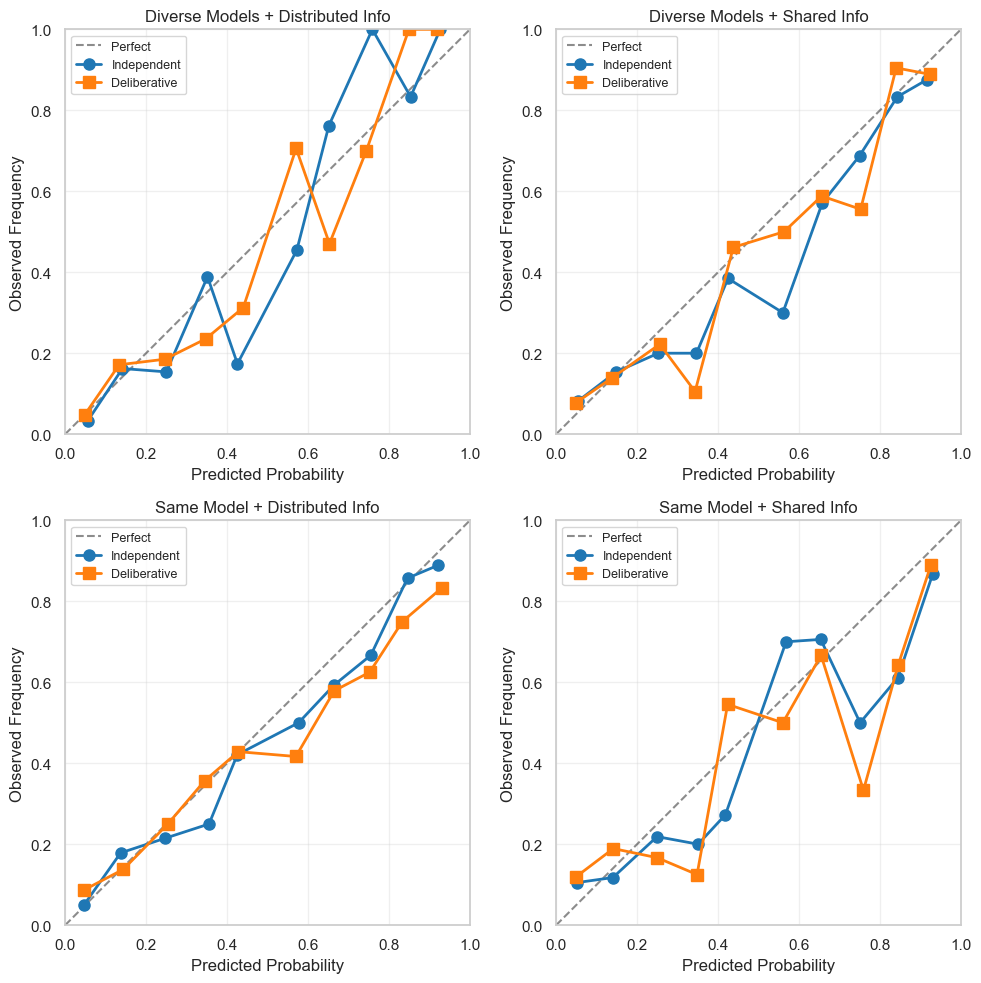

In [226]:
def calibration_curve(probs, outcomes, n_bins=10):
    """Compute calibration curve: bin predictions and compute observed frequencies."""
    probs = np.array(probs) / 100
    outcomes = np.array(outcomes)
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_means, bin_freqs, bin_counts = [], [], []
    
    for i in range(n_bins):
        mask = (probs >= bin_edges[i]) & (probs < bin_edges[i+1])
        if i == n_bins - 1:
            mask = (probs >= bin_edges[i]) & (probs <= bin_edges[i+1])
        if mask.sum() > 0:
            bin_means.append(probs[mask].mean())
            bin_freqs.append(outcomes[mask].mean())
            bin_counts.append(mask.sum())
    
    return np.array(bin_means), np.array(bin_freqs), np.array(bin_counts)

# 2x2 calibration plot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

titles = {
    'diverse_info': 'Diverse Models + Distributed Info',
    'diverse_full': 'Diverse Models + Shared Info',
    'homo_info': 'Same Model + Distributed Info',
    'homo_full': 'Same Model + Shared Info'
}

for ax, cond in zip(axes.flat, PRIMARY_CONDITIONS):
    subset = medians[medians['condition'] == cond]
    
    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect', linewidth=1.5)
    
    # Calibration curves
    pred_ind, freq_ind, _ = calibration_curve(subset['independent_median'], subset['resolution'])
    pred_del, freq_del, _ = calibration_curve(subset['deliberative_median'], subset['resolution'])
    
    ax.plot(pred_ind, freq_ind, 'o-', label='Independent', markersize=8, linewidth=2, color='#1f77b4')
    ax.plot(pred_del, freq_del, 's-', label='Deliberative', markersize=8, linewidth=2, color='#ff7f0e')
    
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Frequency')
    ax.set_title(titles[cond])
    ax.legend(loc='upper left', fontsize=9)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/fig_calibration.png", dpi=150, bbox_inches='tight')
plt.show()

## G. Robustness Check: Brier Score

We replicate the primary analysis using Brier Score instead of Log Loss. Brier Score = (p - outcome)², ranges 0-1, lower is better. Random guessing (50%) = 0.25.

In [227]:
# Brier Score function
def brier_score(prob, outcome):
    """Brier score (mean squared error). Lower is better. Range: 0-1."""
    p = prob / 100
    return (p - outcome) ** 2

# Compute Brier scores for primary analysis
medians['brier_ind'] = brier_score(medians['independent_median'], medians['resolution'])
medians['brier_del'] = brier_score(medians['deliberative_median'], medians['resolution'])
medians['brier_change'] = medians['brier_del'] - medians['brier_ind']

# Brier descriptives
def summarize_brier(df, condition):
    subset = df[df['condition'] == condition]
    return {
        'Scenario': condition,
        'n': len(subset),
        'Independent (mean)': subset['brier_ind'].mean(),
        'Independent (sd)': subset['brier_ind'].std(),
        'Deliberative (mean)': subset['brier_del'].mean(),
        'Deliberative (sd)': subset['brier_del'].std(),
        'Change (mean)': subset['brier_change'].mean(),
        'Change (sd)': subset['brier_change'].std(),
    }

brier_descriptives = pd.DataFrame([summarize_brier(medians, c) for c in PRIMARY_CONDITIONS])
brier_descriptives = brier_descriptives.round(4)
print("Descriptive Statistics (Brier Score)")
print("=" * 60)
brier_descriptives

Descriptive Statistics (Brier Score)


,Scenario,n,Independent (mean),Independent (sd),Deliberative (mean),Deliberative (sd),Change (mean),Change (sd)
0,diverse_info,202,0.1534,0.1878,0.1453,0.2005,-0.0081,0.1015
1,diverse_full,202,0.1621,0.2211,0.1532,0.2195,-0.0088,0.0509
2,homo_info,202,0.1687,0.2142,0.1698,0.2337,0.0010,0.1231
3,homo_full,202,0.1706,0.2397,0.1773,0.2498,0.0067,0.0610


In [228]:
# Paired t-tests with Brier Score
def test_brier(df, condition):
    subset = df[df['condition'] == condition]
    t, p = stats.ttest_rel(subset['brier_ind'], subset['brier_del'])
    change = subset['brier_change'].mean()
    direction = "improves" if change < 0 else "worsens"
    return {
        'Scenario': condition,
        'Mean Change': change,
        'Direction': direction,
        't': t,
        'p': p,
    }

brier_results = pd.DataFrame([test_brier(medians, c) for c in PRIMARY_CONDITIONS])
brier_results = brier_results.round(4)

print("Primary Analysis (Brier Score)")
print("=" * 60)
brier_results

Primary Analysis (Brier Score)


,Scenario,Mean Change,Direction,t,p
0,diverse_info,-0.0081,improves,1.1364,0.2571
1,diverse_full,-0.0088,improves,2.4692,0.0144
2,homo_info,0.0010,worsens,-0.1196,0.9049
3,homo_full,0.0067,worsens,-1.5637,0.1195


In [229]:
# Side-by-side comparison: Log Loss vs Brier Score
comparison = pd.DataFrame({
    'Scenario': PRIMARY_CONDITIONS,
    'LogLoss Δ': primary_results['Mean Change'].values,
    'LogLoss p': primary_results['p'].values,
    'Brier Δ': brier_results['Mean Change'].values,
    'Brier p': brier_results['p'].values,
})

print("Comparison: Log Loss vs Brier Score")
print("=" * 60)
comparison

Comparison: Log Loss vs Brier Score


,Scenario,LogLoss Δ,LogLoss p,Brier Δ,Brier p
0,diverse_info,-0.0224,0.1817,-0.0081,0.2571
1,diverse_full,-0.0199,0.0167,-0.0088,0.0144
2,homo_info,0.0079,0.7168,0.0010,0.9049
3,homo_full,0.0200,0.1436,0.0067,0.1195


## H. Model Comparison (Individual Level)

Which LLM is the best forecaster? We compare raw forecast accuracy at the individual level (no aggregation).

**Fair comparison:** We use only `diverse_full` and `diverse_none` conditions where all three models forecast the same 202 questions with identical information.

In [230]:
# Load raw forecasts (individual level, no aggregation)
forecasts = pd.read_csv(f"{DATA_DIR}/forecasts.csv")

# Filter to independent stage only (deliberative has dependencies between models)
ind_forecasts = forecasts[forecasts['stage'] == 'independent'].copy()

# Filter to fair comparison conditions: diverse_full and diverse_none
# In these conditions, all 3 models get identical info on identical questions
fair_conditions = ['diverse_full', 'diverse_none']

# For independent forecasts, we need to identify which condition they belong to
# Use info_label: 'full' or 'none' for the fair comparison
fair_forecasts = ind_forecasts[ind_forecasts['info_label'].isin(['full', 'none'])].copy()

# Exclude instanced forecasts (e.g., "sonnet-full-1") - these are homo condition duplicates
# Keep only the base forecasts (no instance suffix in forecast_id)
fair_forecasts = fair_forecasts[~fair_forecasts['forecast_id'].str.contains(r'-\d$', regex=True)]

# Compute log loss for each forecast
fair_forecasts['logloss'] = log_loss(fair_forecasts['probability'], fair_forecasts['resolution'])
fair_forecasts['brier'] = brier_score(fair_forecasts['probability'], fair_forecasts['resolution'])

print(f"Individual forecasts for fair comparison: {len(fair_forecasts)}")
print(f"Breakdown by model and info:")
print(fair_forecasts.groupby(['model', 'info_label']).size().unstack(fill_value=0))

Individual forecasts for fair comparison: 1212
Breakdown by model and info:
info_label  full  none
model                 
gpt5         202   202
pro          202   202
sonnet       202   202


In [231]:
# Descriptive statistics by model
model_stats = fair_forecasts.groupby('model').agg(
    n=('logloss', 'count'),
    logloss_mean=('logloss', 'mean'),
    logloss_sd=('logloss', 'std'),
    brier_mean=('brier', 'mean'),
    brier_sd=('brier', 'std'),
).round(4)

print("Model Accuracy (Individual Forecasts)")
print("=" * 60)
print("Lower is better. Brier 0.25 = random guessing.")
print()
model_stats

Model Accuracy (Individual Forecasts)
Lower is better. Brier 0.25 = random guessing.



,n,logloss_mean,logloss_sd,brier_mean,brier_sd
model,,,,,
gpt5,404,0.5235,0.6832,0.1649,0.2282
pro,404,0.5878,0.7943,0.1892,0.2612
sonnet,404,0.5313,0.5848,0.1755,0.2178


In [232]:
# Break down by model AND information level
model_info_stats = fair_forecasts.groupby(['info_label', 'model']).agg(
    n=('logloss', 'count'),
    logloss_mean=('logloss', 'mean'),
    logloss_sd=('logloss', 'std'),
    brier_mean=('brier', 'mean'),
    brier_sd=('brier', 'std'),
).round(4)

print("Model Accuracy by Information Level")
print("=" * 60)
model_info_stats

Model Accuracy by Information Level


n  logloss_mean  logloss_sd  brier_mean  brier_sd
info_label model                                                      
full       gpt5    202        0.4797      0.6023      0.1516    0.2114
           pro     202        0.5830      0.7488      0.1911    0.2671
           sonnet  202        0.5231      0.6127      0.1714    0.2263
none       gpt5    202        0.5673      0.7545      0.1782    0.2437
           pro     202        0.5926      0.8391      0.1873    0.2558
           sonnet  202        0.5396      0.5569      0.1796    0.2095

In [233]:
# Statistical test: One-way ANOVA (are models different?)
# Separate tests for shared info and no info conditions

print("Statistical Tests: Do models differ in accuracy?")
print("=" * 60)

for info in ['full', 'none']:
    subset = fair_forecasts[fair_forecasts['info_label'] == info]
    groups = [subset[subset['model'] == m]['logloss'].values for m in ['gpt5', 'pro', 'sonnet']]
    
    # One-way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"\n{info.upper()} information (n=202 per model):")
    print(f"  ANOVA: F = {f_stat:.4f}, p = {p_val:.4f}")
    
    # If significant, do pairwise comparisons
    if p_val < 0.05:
        print("  Pairwise t-tests (Bonferroni corrected):")
        pairs = [('gpt5', 'pro'), ('gpt5', 'sonnet'), ('pro', 'sonnet')]
        for m1, m2 in pairs:
            g1 = subset[subset['model'] == m1]['logloss'].values
            g2 = subset[subset['model'] == m2]['logloss'].values
            t, p = stats.ttest_ind(g1, g2)
            p_corrected = min(p * 3, 1.0)  # Bonferroni
            sig = "*" if p_corrected < 0.05 else ""
            print(f"    {m1} vs {m2}: t = {t:.3f}, p = {p_corrected:.4f} {sig}")

Statistical Tests: Do models differ in accuracy?

FULL information (n=202 per model):
  ANOVA: F = 1.2540, p = 0.2861

NONE information (n=202 per model):
  ANOVA: F = 0.2687, p = 0.7645


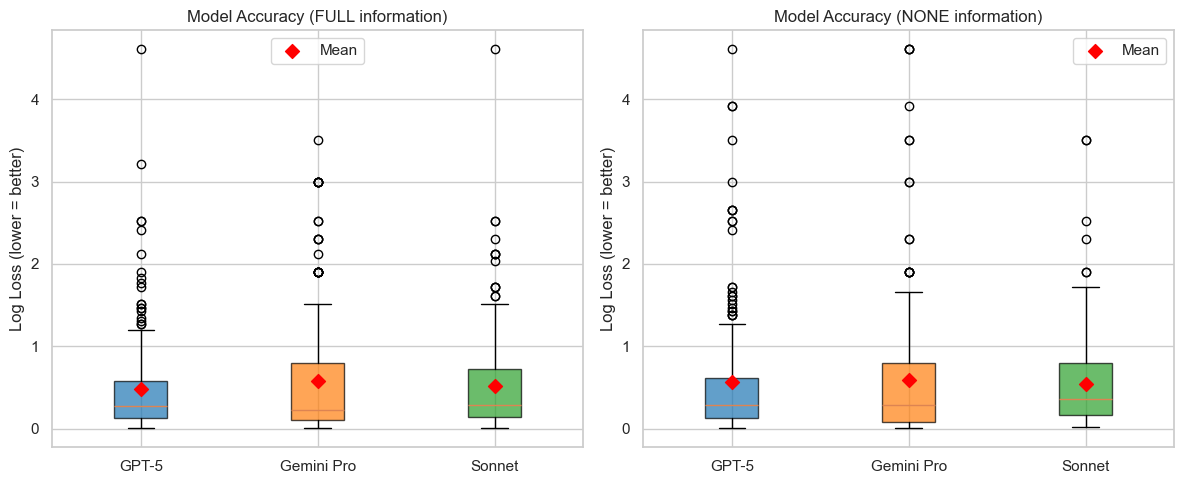

In [234]:
# Visualization: Model accuracy comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, info in zip(axes, ['full', 'none']):
    subset = fair_forecasts[fair_forecasts['info_label'] == info]
    
    # Box plot
    models = ['gpt5', 'pro', 'sonnet']
    model_labels = ['GPT-5', 'Gemini Pro', 'Sonnet']
    data = [subset[subset['model'] == m]['logloss'].values for m in models]
    
    bp = ax.boxplot(data, labels=model_labels, patch_artist=True)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add mean markers
    means = [d.mean() for d in data]
    ax.scatter(range(1, 4), means, color='red', marker='D', s=50, zorder=3, label='Mean')
    
    ax.set_ylabel('Log Loss (lower = better)')
    ax.set_title(f'Model Accuracy ({info.upper()} information)')
    ax.legend()

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/fig_model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()